In [1]:
!echo "List of Intel GPUs available on the system:"
!xpu-smi  discovery 2> /dev/null
!echo "Intel Xeon CPU used by this notebook:"
!lscpu | grep "Model name"

List of Intel GPUs available on the system:
+-----------+--------------------------------------------------------------------------------------+
| Device ID | Device Information                                                                   |
+-----------+--------------------------------------------------------------------------------------+
| 0         | Device Name: Intel(R) Data Center GPU Max 1100                                       |
|           | Vendor Name: Intel(R) Corporation                                                    |
|           | UUID: 00000000-0000-0029-0000-002f0bda8086                                           |
|           | PCI BDF Address: 0000:29:00.0                                                        |
|           | DRM Device: /dev/dri/card1                                                           |
|           | Function Type: physical                                                              |
+-----------+----------------------------------

In [2]:
# !pip install -q peft transformers bitsandbytes datasets sacrebleu
import sys
import site
from pathlib import Path

!echo "Installation in progress, please wait..."
!{sys.executable} -m pip cache purge > /dev/null
!{sys.executable} -m pip install librosa --no-warn-script-location > /dev/null
!{sys.executable} -m pip install seaborn --no-warn-script-location > /dev/null
# !{sys.executable} -m pip install sklearn --no-warn-script-location > /dev/null 
!{sys.executable} -m pip install datasets==2.15 --no-warn-script-location > /dev/null 2>&1 
!{sys.executable} -m pip install fsspec==2023.9.2 > /dev/null  2>&1
!echo "Installation completed."

def get_python_version():
    return "python" + ".".join(map(str, sys.version_info[:2]))

def set_local_bin_path():
    local_bin = str(Path.home() / ".local" / "bin") 
    local_site_packages = str(
        Path.home() / ".local" / "lib" / get_python_version() / "site-packages"
    )
    sys.path.append(local_bin)
    sys.path.insert(0, site.getusersitepackages())
    sys.path.insert(0, sys.path.pop(sys.path.index(local_site_packages)))

set_local_bin_path()

Installation in progress, please wait...
Installation completed.


In [10]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio
from datasets import Audio, load_dataset

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [12]:
dataset = load_dataset("PolyAI/minds14", "en-US", split="train")
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

Generating train split: 0 examples [00:00, ? examples/s]

In [44]:
dataset[0]

{'path': '/home/u87f06e1be6c4a18ca01cf4c55c8c26d/.cache/huggingface/datasets/downloads/extracted/1965a9947f2117954ee4ee68609470e853d3c6428e9fc85f24c18cfc7c01cfc8/en-US~JOINT_ACCOUNT/602ba55abb1e6d0fbce92065.wav',
 'audio': {'path': '/home/u87f06e1be6c4a18ca01cf4c55c8c26d/.cache/huggingface/datasets/downloads/extracted/1965a9947f2117954ee4ee68609470e853d3c6428e9fc85f24c18cfc7c01cfc8/en-US~JOINT_ACCOUNT/602ba55abb1e6d0fbce92065.wav',
  'array': array([ 1.70562416e-05,  2.18727451e-04,  2.28099874e-04, ...,
          3.43842403e-05, -5.96364771e-06, -1.76846661e-05]),
  'sampling_rate': 16000},
 'transcription': 'I would like to set up a joint account with my partner',
 'english_transcription': 'I would like to set up a joint account with my partner',
 'intent_class': 11,
 'lang_id': 4}

In [18]:
def create_waveplot(data, sr):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for original audio', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for original audio', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

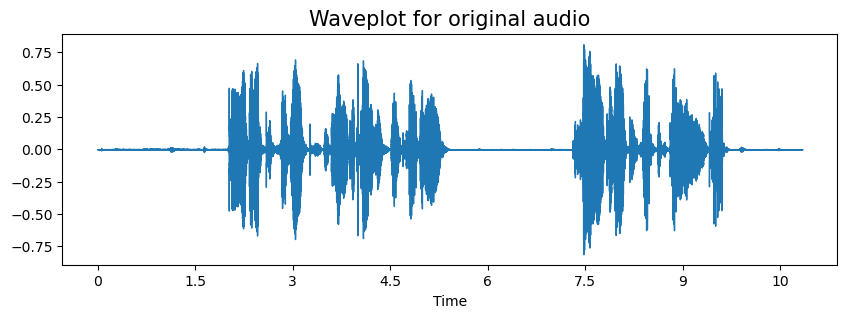

Audio(sampling_rate={'path': '/home/u87f06e1be6c4a18ca01cf4c55c8c26d/.cache/huggingface/datasets/downloads/extracted/1965a9947f2117954ee4ee68609470e853d3c6428e9fc85f24c18cfc7c01cfc8/en-US~JOINT_ACCOUNT/602ba55abb1e6d0fbce92065.wav', 'array': array([ 1.70562416e-05,  2.18727451e-04,  2.28099874e-04, ...,
        3.43842403e-05, -5.96364771e-06, -1.76846661e-05]), 'sampling_rate': 16000}, mono=True, decode=True, id=None)

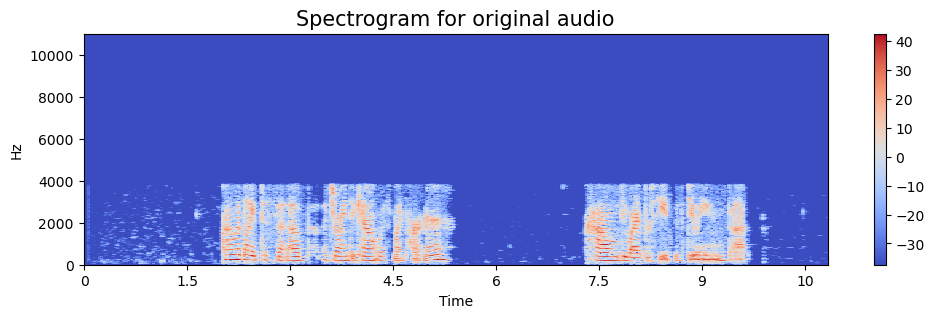

In [25]:
path = dataset[0]['path']
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(dataset[0]['audio'])

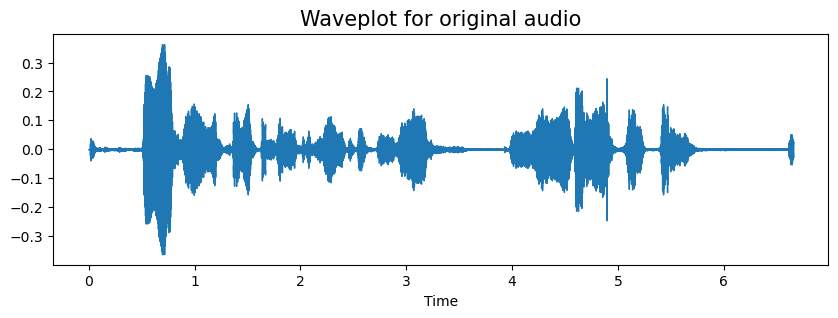

Audio(sampling_rate='/home/u87f06e1be6c4a18ca01cf4c55c8c26d/.cache/huggingface/datasets/downloads/extracted/1965a9947f2117954ee4ee68609470e853d3c6428e9fc85f24c18cfc7c01cfc8/en-US~JOINT_ACCOUNT/602baf24bb1e6d0fbce922a7.wav', mono=True, decode=True, id=None)

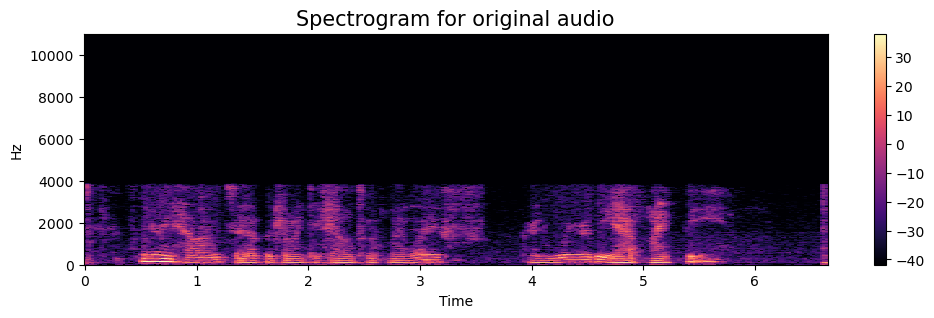

In [20]:
path = dataset[1]['path']
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

In [39]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps = pitch_factor)

# taking any example and checking for techniques.
path = dataset[4]['path']
data, sample_rate = librosa.load(path)

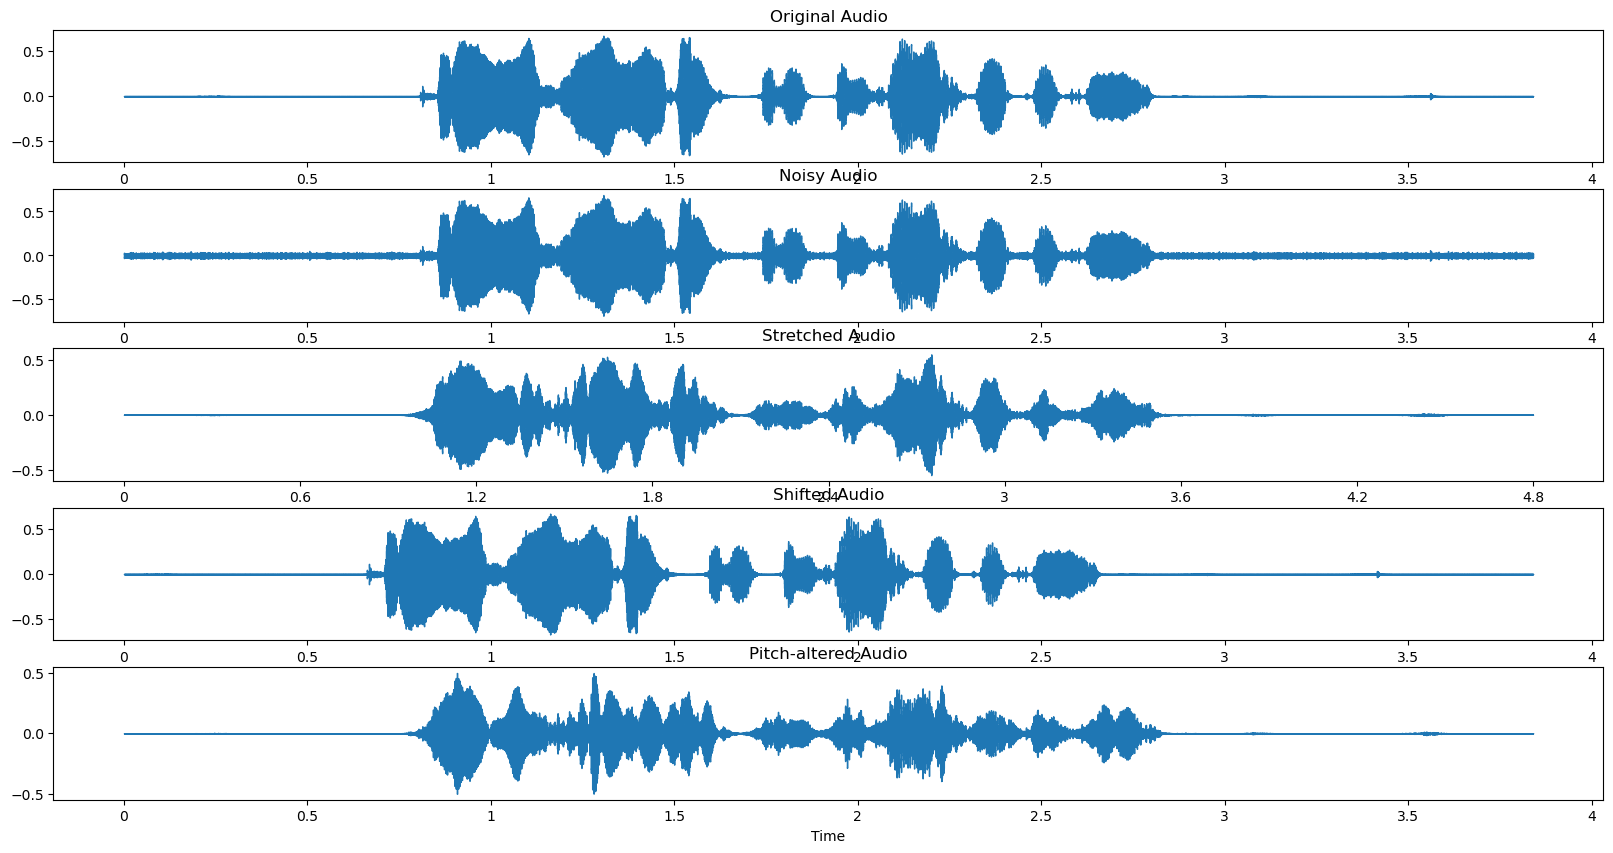

In [43]:
fig, axs = plt.subplots(5, figsize=(20, 10))
librosa.display.waveshow(y=data, sr=sample_rate, ax=axs[0])
axs[0].set_title('Original Audio')
x = noise(data)
librosa.display.waveshow(y=x, sr=sample_rate, ax=axs[1])
axs[1].set_title('Noisy Audio')
x = stretch(data)
librosa.display.waveshow(y=x, sr=sample_rate, ax=axs[2])
axs[2].set_title('Stretched Audio')
x = shift(data)
librosa.display.waveshow(y=x, sr=sample_rate, ax=axs[3])
axs[3].set_title('Shifted Audio')
x = pitch(data, sample_rate)
librosa.display.waveshow(y=x, sr=sample_rate, ax=axs[4])
axs[4].set_title('Pitch-altered Audio')
plt.show()

In [45]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [50]:
X, Y = [], []
for path, emotion in zip(dataset['path'], dataset['intent_class']):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [52]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.093049,0.456914,0.479288,0.577673,0.536818,0.500723,0.580031,0.589667,0.548740,0.585816,...,3.078404e-08,2.958213e-08,2.857398e-08,2.769227e-08,2.694045e-08,2.633843e-08,2.585431e-08,2.551809e-08,2.529921e-08,11
1,0.360510,0.726319,0.756966,0.801073,0.777428,0.753362,0.722659,0.735928,0.721490,0.748425,...,3.951686e-02,4.011881e-02,3.912795e-02,4.027427e-02,4.111879e-02,4.113740e-02,4.195090e-02,4.098445e-02,4.023387e-02,11
2,0.099884,0.529882,0.468496,0.460575,0.535476,0.600733,0.490521,0.490683,0.615531,0.566755,...,1.040055e-06,1.204036e-06,1.336487e-06,1.360124e-06,9.899105e-07,9.894123e-07,7.401690e-07,3.850572e-07,6.339815e-08,11
3,0.045817,0.496054,0.528630,0.578174,0.533761,0.486866,0.531350,0.631570,0.673377,0.718316,...,1.375399e-06,1.269839e-06,1.179679e-06,1.102604e-06,1.038950e-06,9.890130e-07,9.509540e-07,9.248589e-07,9.088938e-07,11
4,0.054633,0.523129,0.555301,0.602550,0.560355,0.512464,0.544013,0.638820,0.678155,0.722162,...,3.346985e-05,3.419099e-05,3.276319e-05,3.333785e-05,3.165199e-05,3.337381e-05,3.427633e-05,3.302643e-05,3.328473e-05,11


In [53]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [55]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, test_size=0.1, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1520, 162), (1520,), (169, 162), (169,))

In [56]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1520, 162), (1520,), (169, 162), (169,))

In [57]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1520, 162, 1), (1520,), (169, 162, 1), (169,))

In [84]:
import torch
from torch import nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(162, 256, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        
        self.conv2 = nn.Conv1d(256, 256, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        
        self.conv3 = nn.Conv1d(256, 128, kernel_size=5, stride=1, padding=2)
        self.pool3 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        self.dropout1 = nn.Dropout(0.2)
        
        self.conv4 = nn.Conv1d(128, 64, kernel_size=5, stride=1, padding=2)
        self.pool4 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        
        self.fc1 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(32, 14)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.dropout1(x)
        
        x = torch.relu(self.conv4(x))
        x = self.pool4(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        
        x = torch.softmax(self.fc2(x), dim=1)
        return x

model = Net()
print(model)

Net(
  (conv1): Conv1d(162, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool1): MaxPool1d(kernel_size=5, stride=2, padding=2, dilation=1, ceil_mode=False)
  (conv2): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool2): MaxPool1d(kernel_size=5, stride=2, padding=2, dilation=1, ceil_mode=False)
  (conv3): Conv1d(256, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool3): MaxPool1d(kernel_size=5, stride=2, padding=2, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv4): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool4): MaxPool1d(kernel_size=5, stride=2, padding=2, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=14, bias=True)
)


In [85]:
from torch.utils.data import TensorDataset, DataLoader
x_train_tensor = x_train_tensor.float()
y_train_tensor = y_train_tensor.long()
x_test_tensor = x_test_tensor.float()
y_test_tensor = y_test_tensor.long()

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [86]:
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=2, verbose=True, min_lr=1e-7)
criterion = nn.CrossEntropyLoss()

In [88]:
num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Reset the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        train_loss += loss.item()
    train_losses.append(train_loss/len(train_loader))  # Average training loss for this epoch

    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    with torch.no_grad():  # Do not calculate gradients for the following block
        for inputs, targets in test_loader:
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute the loss
            test_loss += loss.item()
    test_losses.append(test_loss/len(test_loader))  # Average test loss for this epoch

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}')

    scheduler.step(test_loss)  # Step the learning rate scheduler

Epoch 1/100, Train Loss: 2.5931167801221213, Test Loss: 2.6273556550343833
Epoch 2/100, Train Loss: 2.5965708593527475, Test Loss: 2.6273555755615234
Epoch 3/100, Train Loss: 2.5935703217983246, Test Loss: 2.6273542245229087
Epoch 4/100, Train Loss: 2.5942645370960236, Test Loss: 2.6273533503214517
Epoch 5/100, Train Loss: 2.595011701186498, Test Loss: 2.6273531119028726
Epoch 6/100, Train Loss: 2.59489298860232, Test Loss: 2.627351919809977
Epoch 7/100, Train Loss: 2.5934505462646484, Test Loss: 2.6273507277170816
Epoch 8/100, Train Loss: 2.5950769782066345, Test Loss: 2.6273491382598877
Epoch 9/100, Train Loss: 2.596816827853521, Test Loss: 2.6273483435312905
Epoch 10/100, Train Loss: 2.5953964491685233, Test Loss: 2.6273476282755532
Epoch 11/100, Train Loss: 2.596170167128245, Test Loss: 2.627347946166992
Epoch 12/100, Train Loss: 2.5971674422423043, Test Loss: 2.6273473103841147
Epoch 13/100, Train Loss: 2.594683587551117, Test Loss: 2.6273484230041504
Epoch 14/100, Train Loss: 2.5